In [34]:
# add capability to import from parent directory
import sys, os
sys.path.insert(1, os.path.join(os.path.abspath('.'), '..'))

import pvmismatch as pvm
import numpy as np

import matplotlib.pyplot as plt

In [68]:
# Setting PV system layout cell and module parameters
v_bypass = np.float64(-0.5)  # [V] trigger voltage of bypass diode
cell_area = np.float64(246.49)  # [cm^2] cell area
Isc0_T0 = 9.68 # [A] reference short circuit current
ncols_per_substr=[2]*3 # 3 bypass diodes with 2 series connected cell-columns
nrows=10 # number of cell rows in the module

# Building PV modules and system
pv_mod_pattern = pvm.pvmodule.standard_cellpos_pat(nrows=nrows,
                                                   ncols_per_substr=ncols_per_substr)
pv_mod = pvm.pvmodule.PVmodule(cell_pos=pv_mod_pattern, pvcells=None,
                               pvconst=None, Vbypass=v_bypass, cellArea=cell_area)


In [41]:
pv_cells = pv_mod.pvcells
for c in pv_cells:
    c.update(diode_model = 'desoto', aRBD=0.0, bRBD=0.0, Isc0_T0 = Isc0_T0) # updating short circuit currents

pv_mod.setSuns(cells=list(range(0, len(pv_cells))), Ee=[1]*len(pv_cells))

pv_str = pvm.pvstring.PVstring(numberMods=str_len, pvmods=[pv_mod]*str_len)

pv_sys = pvm.pvsystem.PVsystem(numberStrs=str_num, pvstrs=[pv_str]*str_num,
                               numberMods=[str_len]*str_num,
                               pvmods=[pv_mod]*str_len)

<PVcell(Ee=1[suns], Tcell=298.15[K], Isc=9.68[A], Voc=0.687842[V])>
(9.684125625749223, 2.28618816125344e-11, 0.004267236774264931, 10.01226369025448, 0.025692570400413114)


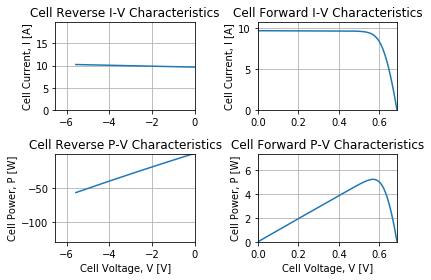

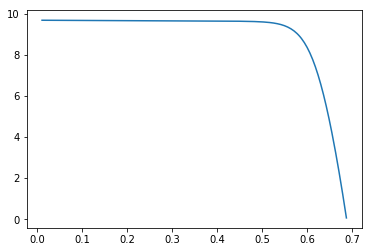

In [42]:
pv_cells[0].plot()

print(pv_mod.pvcells[0])

(photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth) = pv_mod.pvcells[0].Igen, \
    pv_mod.pvcells[0].Isat1, pv_mod.pvcells[0].Rs, pv_mod.pvcells[0].Rsh, pv_mod.pvcells[0].N1 * pv_mod.pvcells[0].Vt
print((photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth))

(V_pvm, I_pvm) = pv_mod.pvcells[0].Vcell, pv_mod.pvcells[0].Icell
I_pvm = I_pvm[(V_pvm>=0) & (V_pvm<=pv_mod.pvcells[0].Voc)]
V_pvm = V_pvm[(V_pvm>=0) & (V_pvm<=pv_mod.pvcells[0].Voc)]

plt.figure()
plt.plot(V_pvm, I_pvm)
plt.show()

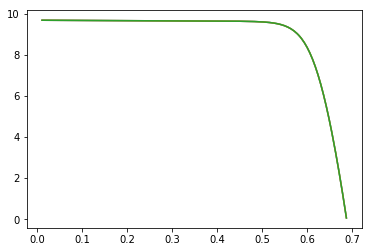

In [48]:
import pvlib

v_pvl = V_pvm
i_pvl_brentq = pvlib.pvsystem.i_from_v(resistance_shunt, resistance_series, nNsVth, V_pvm, saturation_current, photocurrent,
                                       method='brentq')
i_pvl_newton = pvlib.pvsystem.i_from_v(resistance_shunt, resistance_series, nNsVth, V_pvm, saturation_current, photocurrent,
                                       method='newton')
i_pvl_lambertw = pvlib.pvsystem.i_from_v(resistance_shunt, resistance_series, nNsVth, V_pvm, saturation_current, photocurrent,
                                         method='lambertw')

plt.plot(v_pvl, i_pvl_brentq)
plt.plot(v_pvl, i_pvl_lambertw)
plt.plot(v_pvl, i_pvl_newton)

1.763860724146582e-10


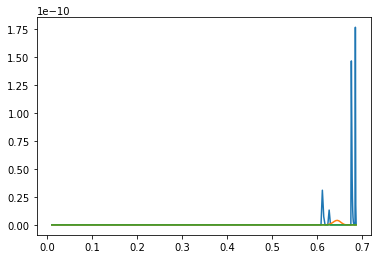

In [49]:
plt.plot(v_pvl, np.abs(i_pvl_brentq - I_pvm))
plt.plot(v_pvl, np.abs(i_pvl_newton - I_pvm))
plt.plot(v_pvl, np.abs(i_pvl_lambertw - I_pvm))
print(np.max(np.abs(i_pvl_lambertw - i_pvl_brentq)))

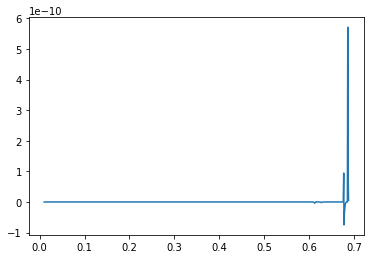

In [46]:
plt.plot(V_pvm, (I_pvm - i_pvl_brentq) / I_pvm)

4.49089099241462e-10
7.028155835087091e-12
2.7977620220553945e-14


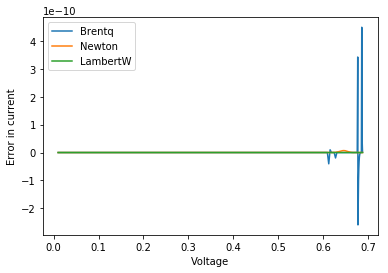

In [59]:
def sde_resid(v, i, iph, io, rs, rsh, nNsVth):
    """
    Calculate the residual for current for a single diode equation at (v, i).
    """
    return iph - io * np.expm1((v + i * rs) / nNsVth) - (v + i * rs) / rsh - i

i_resid_lambertw = sde_resid(v_pvl, i_pvl_lambertw, iph=photocurrent, io=saturation_current,
                             rs=resistance_series, rsh=resistance_shunt, nNsVth=nNsVth)
i_resid_brentq = sde_resid(v_pvl, i_pvl_brentq, iph=photocurrent, io=saturation_current,
                           rs=resistance_series, rsh=resistance_shunt, nNsVth=nNsVth)
i_resid_newton = sde_resid(v_pvl, i_pvl_newton, iph=photocurrent, io=saturation_current,
                           rs=resistance_series, rsh=resistance_shunt, nNsVth=nNsVth)

plt.plot(v_pvl, i_resid_brentq)
plt.plot(v_pvl, i_resid_newton)
plt.plot(v_pvl, i_resid_lambertw)
plt.legend(['Brentq', 'Newton', 'LambertW'])
plt.ylabel('Error in current')
plt.xlabel('Voltage')
print(np.max(np.abs(i_resid_brentq)))
print(np.max(np.abs(i_resid_newton)))
print(np.max(np.abs(i_resid_lambertw)))


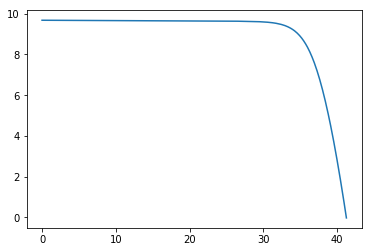

In [67]:
Vmod = pv_mod.Vmod
Imod = pv_mod.Imod
Voc = pv_mod.Voc.sum()
Imod = Imod[(Vmod>=0) & (Vmod<=Voc)]
Vmod = Vmod[(Vmod>=0) & (Vmod<=Voc)]

plt.plot(Vmod, Imod)

In [64]:
Ns = 60


41.270548514676385
